# Class-Decomposition and Augmentation for Imbalanced Data Sentiment Analysis

Please reference this method as follows:

Elyan E, Moreno-García CF, Jayne C. CDSMOTE: class decomposition and synthetic minority class oversampling technique for imbalanced-data classification. Neural Comput Appl [Internet]. 2020; Available from: https://doi.org/10.1007/s00521-020-05130-z

or use the BibTex entry below:

@article{Elyan2020,
author = {Elyan, Eyad and Moreno-Garcia, Carlos Francisco and Jayne, Chrisina},
doi = {10.1007/s00521-020-05130-z},
isbn = {0123456789},
issn = {1433-3058},
journal = {Neural Computing and Applications},
publisher = {Springer London},
title = {{CDSMOTE: class decomposition and synthetic minority class oversampling technique for imbalanced-data classification}},
url = {https://doi.org/10.1007/s00521-020-05130-z},
year = {2020}
}

In [1]:
## Import necessary packages
import sys
import clustData
import computeKVs
import numpy as np
import csv
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

To test this method, we will use features extracted using [GloVe](https://nlp.stanford.edu/projects/glove/) from the [Global Warming dataset](ttps://data.world/crowdflower/sentiment-of-climate-change), which contains tweets of people claiming no existence (class 0), neutral opinions (class 1) or support of the existence (class 2) of global warming.

In [2]:
dataset = 'data_encoded_glwarmingGloVe' # name of the csv file containing the data and target

To apply the CDSMOTE method, we need to define the following parameters:

* `classdecomp`: You can select different algorithms to cluster in the CD step. According to our experimental results, DBSCAN yields the best outcomes for sentiment analysis given the cosine similarity distance calculation.
* `oversampler`: You can choose between SMOTE or ADASYN for the oversampling step. Currently we have always implemented SMOTE, hence the name of the method
* `n_clusters`:
* `EPS`:
* `threshold`:

In [3]:
classdecomp = 'DBSCAN' # 'kmeans', 'FCmeans', 'FCmeansOptimised' and 'DBSCAN' available 
oversampler = 'SMOTE' # 'SMOTE' and 'ADASYN' available
n_clusters = 4 # used in option "fixed" and only if clusterings = "Kmeans" || "FCmeans"
number_of_tests = 5 # How many times to repeat the SVM experiment comparing the original and new db
EPS = 0.5 # clustering value if DBSCAN is used
threshold = 10 # if samples in positive class are apart from average by more than this value, apply oversampling

**STEP 1:** Loading the dataset


###### Dataset: data_encoded_glwarmingGloVe ##########

  Class  Number of Samples
0     0               1117
1     1               1862
2     2               3111
Total samples: 6090

Showing class distribution bar chart...


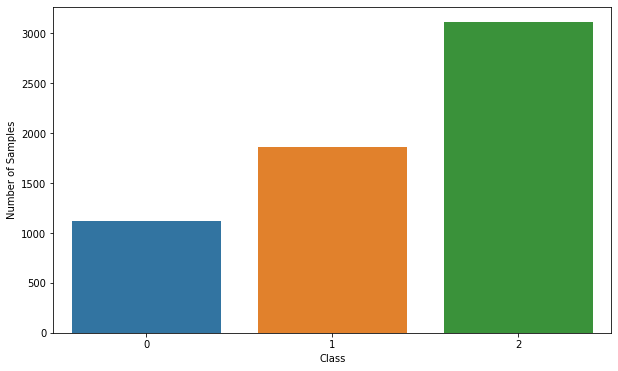

In [4]:
## 1. Load dataset
with open('data//'+str(dataset)+'.csv', 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    data = []
    target = []
    for row in reader:
        data.append(list(map(float,row[0:len(row)-1])))
        target.append(row[-1])
del row, reader, f

## 1.a. 0-1 Standarisation, not used since datasets are very big and crashes
# from sklearn import preprocessing
# data = preprocessing.scale(data)

## 1.b. Correct targets (airline & glwarming db's)
if 'airline' in dataset or 'glwarming' in dataset:
    for i,j in enumerate(target):
        if j == '0.000000000000000000e+00': 
            target[i] = '0'
        elif j == '1.000000000000000000e+00': 
            target[i] = '1'
        elif j == '2.000000000000000000e+00': 
            target[i] = '2'

## 2. Find majority and minority classes
majority_class = max(set(target), key=target.count)
minority_class = min(set(target), key=target.count)

## 3. Plot distribution of original dataset
print('\n###### Dataset: '+str(dataset)+' ##########\n')
histo = [['Class','Number of Samples']]
for i, label1 in enumerate(sorted(list(set(target)))):
    cont = 0
    for j, label2 in enumerate(target):
        if label1 == label2:
            cont+=1
    histo.append([label1,cont])
histo.append(['Total Samples', len(target)])
# Load as a panda
histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
print(histo_panda)
print('Total samples: '+str(len(target)))
# Create a histogram using seaborn
sns_plot = sns.barplot(x="Class", y="Number of Samples", data=histo_panda)
# Save the image
sns_plot.figure.set_size_inches(10, 6)
print('\nShowing class distribution bar chart...')
plt.show()

**STEP 2:** Apply class decomposition. Notice that when using DBSCAN, it is likely that all classes get decomposed regardless of whether they are minority or majority classes.


Class decomposition by applying DBSCAN...
Number of clusters found for class 0: 2
Number of clusters found for class 1: 6
Number of clusters found for class 2: 8
    Class  Number of Samples
0   0_c-1               1109
1    0_c0                  8
2   1_c-1               1818
3    1_c0                  7
4    1_c1                  6
5    1_c2                  7
6    1_c3                 18
7    1_c4                  6
8   2_c-1               3044
9    2_c0                 14
10   2_c1                  8
11   2_c2                  7
12   2_c3                  7
13   2_c4                  9
14   2_c5                 14
15   2_c6                  8
Total samples: 6090
Average number of samples per class: 380.625

Showing class distribution bar chart...


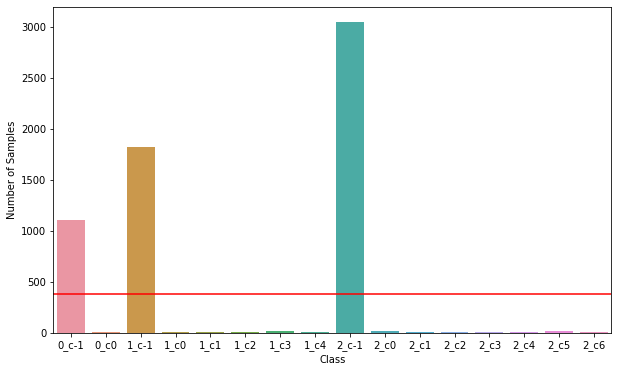

In [5]:
import warnings; warnings.simplefilter('ignore')
## 1. Calculate k vector (for class decomposition)  
k = computeKVs.majority(data, target, n_clusters)

## 2. Cluster the data
if classdecomp.lower()=='kmeans':
    target_cd = clustData.Kmeans(data, target, k)
elif classdecomp.lower()=='fcmeans':
    target_cd = clustData.FCmeans(data, target, k)
elif classdecomp.lower()=='fcmeansoptimised':
     target_cd = clustData.FCmeansOptimised(data, target, max_nclusters = 10)   
elif classdecomp.lower()=='dbscan':        
     target_cd = clustData.DBSCAN(data, target, eps=EPS)
else:
    print('Invalid clustering algorithm selected.')
    sys.exit()

## 3. Plot distribution after cd
histo = [['Class','Number of Samples']]
for i, label1 in enumerate(sorted(list(set(target_cd)))):
    cont = 0
    for j, label2 in enumerate(target_cd):
        if label1 == label2:
            cont+=1
    histo.append([label1,cont])
histo.append(['Total Samples', len(target_cd)])
# Save the histogram as a .csv file   
# Load as a panda
histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
print(histo_panda)
print('Total samples: '+str(len(target_cd)))
# Create a histogram using seaborn
sns_plot = sns.barplot(x="Class", y="Number of Samples", data=histo_panda)
# draw a line depicting the average
indexesUnique = list(set(target_cd))
indexesUnique.sort()
cdclassdist_count = []
cdclassdist_names = []
for cdclass in indexesUnique:
     cdclassdist_count.append(target_cd.count(cdclass))
     cdclassdist_names.append(cdclass)
average = sum(cdclassdist_count)/len(cdclassdist_count)
print('Average number of samples per class:', average)
plt.axhline(average, color='red')
# Save the image
sns_plot.figure.set_size_inches(10, 6)
print('\nShowing class distribution bar chart...')
plt.show()

**STEP 3:** Apply oversampling to the sub-classes of the original minority classes (i.e. class 0 and 1) that are *threshold* samples (in this case, 10) below the average (i.e. red line)

Oversampling class 0_c0...
Oversampling class 1_c0...
Oversampling class 1_c1...
Oversampling class 1_c2...
Oversampling class 1_c3...
Oversampling class 1_c4...
    Class  Number of Samples
0   0_c-1               1109
1    0_c0               1109
2   1_c-1               1818
3    1_c0               1109
4    1_c1               1109
5    1_c2               1109
6    1_c3               1109
7    1_c4               1109
8   2_c-1               3044
9    2_c0                 14
10   2_c1                  8
11   2_c2                  7
12   2_c3                  7
13   2_c4                  9
14   2_c5                 14
15   2_c6                  8
Total samples: 12692
New average number of samples per class: 138.625

Showing class distribution bar chart...


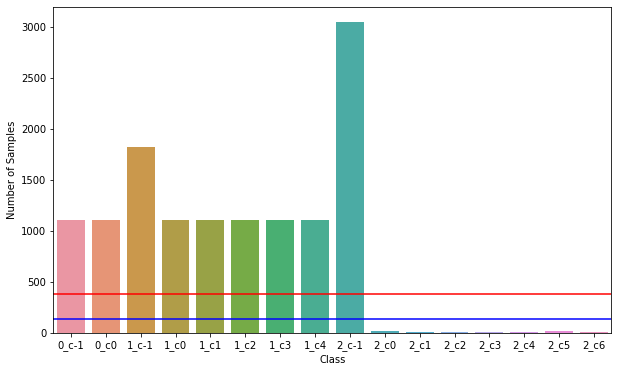

In [6]:
## 1. Calculate reference class (i.e. closest to the average and above it) for oversampling
c = np.inf
ref = majority_class+'_c0' # gets picked by default if none other accomplishes
for i,j in enumerate(cdclassdist_count):
    if abs(j-average)<c and j-average>=0:
        c = abs(j-average)
        ref = cdclassdist_names[i]

data_cdsmote = list(np.asarray(data)[(np.where(np.asarray(target)==majority_class))])
target_cdsmote = list(np.asarray(target_cd)[(np.where(np.asarray(target)==majority_class))])

## 2. For all non-majority classes (considering the original dataset), see if they are far (i.e. difference greater than the threshold) from the average (red line in the last plot)
flag = 0
for i, cdclassdist_name in enumerate(cdclassdist_names):
    if majority_class not in cdclassdist_name.split('_')[0]:
        if abs(average-cdclassdist_count[i])>threshold and average-cdclassdist_count[i]>=0 and cdclassdist_count[i]>5: #>5 because smote can only oversample with over 5 samples!
            flag = 1
            print('Oversampling class '+str(cdclassdist_name)+'...')            
            ## 3. Create a sub-dataset that only contains the new majority and current non-minority classes
            data_majmin = []
            target_majmin = []
            for j, label in enumerate(target_cd):
                if label == cdclassdist_name or label == ref:
                    data_majmin.append(data[j])
                    target_majmin.append(label)
            ## 4. Do the oversampling
            if oversampler.lower() == 'smote':
                sm = SMOTE()
                data_over, target_over = sm.fit_resample(data_majmin, target_majmin) 
            elif oversampler.lower() == 'adasyn':
                ada = ADASYN()
                data_over, target_over = ada.fit_resample(data_majmin, target_majmin)
            else:
                print('Invalid oversampling algorithm.')
                sys.exit() 
            # Append the oversampled data to the new repository
            for j, label in enumerate(target_over):
                if label == cdclassdist_name:
                    data_cdsmote.append(list(data_over[j]))
                    target_cdsmote.append(label)
        else:
            # Append the not-oversampled
            for j, label in enumerate(target_cd):
                if label == cdclassdist_name:
                    data_cdsmote.append(list(data[j]))
                    target_cdsmote.append(label)


## 5. Plot distribution after smote
if flag == 1:
    histo = [['Class','Number of Samples']]
    for i, label1 in enumerate(sorted(list(set(target_cdsmote)))):
        cont = 0
        for j, label2 in enumerate(target_cdsmote):
            if label1 == label2:
                cont+=1
        histo.append([label1,cont])
    histo.append(['Total Samples', len(target_cdsmote)])
    ## Load as a panda
    histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
    print(histo_panda)
    print('Total samples: '+str(len(target_cdsmote)))
    ## Create a histogram using seaborn
    sns_plot = sns.barplot(x="Class", y="Number of Samples", data=histo_panda)
    ## draw a line depicting the average
    indexesUnique = list(set(target_cdsmote))
    indexesUnique.sort()
    newestclassdist_count = []
    for newestclass in indexesUnique:
          newestclassdist_count.append(target_over.count(newestclass))
    average_new = sum(newestclassdist_count)/len(newestclassdist_count)
    print('New average number of samples per class:', average_new)
    plt.axhline(average, color='red')
    plt.axhline(average_new, color='blue')
    ## Save the image
    sns_plot.figure.set_size_inches(10, 6)
    print('\nShowing class distribution bar chart...')
    plt.show()
else:
    print('All non-majority classes are close to average. No oversampling was needed.')

**STEP 4:** Classification (using SVM), comparing the **weighted** *precision*, *recall* and *f1-score* of the original dataset versus the one generated through CDSMOTE. We applied a five fold cross validation.

In [7]:
print('\n')

accuracy_o_final = 0
accuracy_c_final = 0
recall_o_final = 0
recall_c_final = 0
precision_o_final = 0
precision_c_final = 0
f1_o_final = 0
f1_c_final = 0

## Split data/target and data_cdsmote/target_cdsmote (stratified and with many splits)
sss = StratifiedShuffleSplit(n_splits=number_of_tests, 
                             test_size=0.3, random_state=42)

# Original data, only do on the first test for the dataset to save time
experiments = 0
for train_index, test_index in sss.split(data, target):
    # print(train_index, test_index)
    print('\nExperiment '+str(experiments+1)+' Original DB...')
    experiments+=1
    X_train_o, X_test_o = np.asarray(data)[train_index], np.asarray(data)[test_index]
    y_train_o, y_test_o = np.asarray(target)[train_index], np.asarray(target)[test_index]
    clf_o = svm.SVC(kernel='linear')
    clf_o.fit(X_train_o, y_train_o)
    y_pred_o = clf_o.predict(X_test_o)
    # Test         
    print("Precision Original DB:",metrics.precision_score(y_test_o, y_pred_o, average='weighted'))
    print("Recall Original DB:",metrics.recall_score(y_test_o, y_pred_o, average='weighted'))
    print("F1 Score Original DB:",metrics.f1_score(y_test_o, y_pred_o, average='weighted'))
    precision_o_final = precision_o_final + metrics.precision_score(y_test_o, y_pred_o, average='weighted')
    recall_o_final = recall_o_final + metrics.recall_score(y_test_o, y_pred_o, average='weighted')
    f1_o_final = f1_o_final + metrics.f1_score(y_test_o, y_pred_o, average='weighted')

    print('\n------')

# CDSMOTE data
experiments = 0
for train_index, test_index in sss.split(data_cdsmote, target_cdsmote):
    print('\nExperiment '+str(experiments+1)+' CDSMOTE DB...')
    experiments+=1
    X_train_c, X_test_c,  = np.asarray(data_cdsmote)[train_index], np.asarray(data_cdsmote)[test_index]
    y_train_c, y_test_c = np.asarray(target_cdsmote)[train_index], np.asarray(target_cdsmote)[test_index]
    # Train models
    clf_c = svm.SVC(kernel='linear')
    clf_c.fit(X_train_c, y_train_c)
    y_pred_c = clf_c.predict(X_test_c)
    # Test, making sure accuracy considers sub_classes as good
    for i,label in enumerate(y_pred_c):
          y_pred_c[i] = label.split('_')[0]
    for i,label in enumerate(y_test_c):
          y_test_c[i] = label.split('_')[0]
    print("Precision CDSMOTE DB:",metrics.precision_score(y_test_c, y_pred_c, average='weighted'))
    print("Recall CDSMOTE DB:",metrics.recall_score(y_test_c, y_pred_c, average='weighted'))
    print("F1 Score CDSMOTE DB:",metrics.f1_score(y_test_c, y_pred_c, average='weighted'))
    precision_c_final = precision_c_final + metrics.precision_score(y_test_c, y_pred_c, average='weighted')
    recall_c_final = recall_c_final + metrics.recall_score(y_test_c, y_pred_c, average='weighted')
    f1_c_final = f1_c_final + metrics.f1_score(y_test_c, y_pred_c, average='weighted')

print('\n')

# Final results
print('Final Results:')
print("Average Precision Original DB:",precision_o_final/experiments)
print("Average Recall Original DB:",recall_o_final/experiments)
print("Average F1 Score Original DB:",f1_o_final/experiments)
print("Average Precision CDSMOTE DB:",precision_c_final/experiments)
print("Average Recall CDSMOTE DB:",recall_c_final/experiments)
print("Average F1 Score CDSMOTE DB:",f1_c_final/experiments)




Experiment 1 Original DB...
Precision Original DB: 0.6361112430980671
Recall Original DB: 0.6414887794198139
F1 Score Original DB: 0.6287908422179509

------

Experiment 2 Original DB...
Precision Original DB: 0.6115989147885572
Recall Original DB: 0.6190476190476191
F1 Score Original DB: 0.6055929870779531

------

Experiment 3 Original DB...
Precision Original DB: 0.6178776022596104
Recall Original DB: 0.6261631089217297
F1 Score Original DB: 0.6124623767376169

------

Experiment 4 Original DB...
Precision Original DB: 0.6249389365009343
Recall Original DB: 0.6294471811713191
F1 Score Original DB: 0.6170285610602907

------

Experiment 5 Original DB...
Precision Original DB: 0.6266523207670276
Recall Original DB: 0.6327312534209086
F1 Score Original DB: 0.6229949232551957

------

Experiment 1 CDSMOTE DB...
Precision CDSMOTE DB: 0.8418462403780761
Recall CDSMOTE DB: 0.8290441176470589
F1 Score CDSMOTE DB: 0.8327006557010206

Experiment 2 CDSMOTE DB...
Precision CDSMOTE DB: 0.8362

Notice the the *weighted f1-score* when classifying this dataset increases from 0.61 to 0.83!